# Time

This text is almost in whole based on the text made by Luc at the [orekit webpage](https://www.orekit.org/site-orekit-10.1/architecture/time.html)



In [1]:
# First initiate notebook parameters
%pylab inline
figsize(10,10)

#initialize orekit and JVM
import orekit
orekit.initVM()

from orekit.pyhelpers import setup_orekit_curdir
setup_orekit_curdir()

Populating the interactive namespace from numpy and matplotlib


The "Time" package is an independent package providing classes to handle epochs and time scales, and to compare instants.


## Time Presentation

The principal class is *AbsoluteDate* which represents a unique instant in time, so as to be able to locate it with respect to the many different times scales in use in the space dynamics and astronomy fields.
This greatly simplifies development as it hides some models internals. For example when using JPL-based ephemerides, time must be in Terrestrial Time (formerly known as Ephemeris Time). However, this is an implementation detail and someone calling Orekit from a high level application should not have to deal with it. The *AbsoluteDate* class allows users to pass a date regardless of the time scale it was defined in, conversions will be done as required transparently.

### Time Scales

Dates are commonly defined by specifying a point in a specific time scale. For example, the J2000.0 epoch is defined from its calendar components as 2000-01-01T12:00:00 in Terrestrial Time. It is of prime importance to understand the various available time scales definitions to avoid mistakes. The TimeScalesFactory class provides several predefined time scales:

* [**International Atomic Time**](https://en.wikipedia.org/wiki/International_Atomic_Time), TAI this is the most accurate and regular time scale that can be used at the surface of the Earth.
* **Terrestrial Time** as defined by IAU (1991) recommendation IV. Coordinate time at the surface of the Earth. It is the successor of Ephemeris Time TE. By convention, TT = TAI + 32.184 s.
* **Universal Time Coordinate**. UTC is mainly related to TAI, but some step adjustments are introduced from time to time to take into account Earth rotation irregularities and to prevent the legal time from drifting with respect to day and night. The International Earth Rotation Service (IERS) is in charge of this time-keeping. These adjustments require introduction of leap seconds, which means some days are not 86400 seconds long.
* **Universal Time 1**. UT1 is a time scale directly linked to the actual rotation of the Earth. It is an irregular scale, reflecting Earth's irregular rotation rate. The offset between UT1 and UTCScale is found in the Earth Orientation Parameters published by IERS.
* **Geocentric Coordinate Time**. Coordinate time at the center of mass of the Earth. This time scale depends linearly on TTScale (and hence on TAI),
* **Barycentric Dynamic Time**. Time used to compute ephemerides in the solar system. This time is offset with respect to TT by small relativistic corrections due to Earth motion,
* **Barycentric Coordinate Time**. Coordinate time used for computations in the solar system. This time scale depends linearly on TDBScale.
* **Global Positioning System reference scale**. This scale was equal to UTC at start of the GPS Epoch when UTC was 19 seconds behind TAI, and has stayed parallel to TAI since then (i.e. UTC is now offset from GPS due to leap seconds). TGPS = TAI - 19 s.
* **Greenwich Mean Sidereal Time scale**. The Greenwich Mean Sidereal Time is the hour angle between the meridian of Greenwich and mean equinox of date at 0h UT1.

Orekit supports both the linear models of UTC-TAI offsets used between 1961 and 1972 and the constant models with only whole seconds offsets (and leap seconds) used since 1972. See example in end of notebook for the evolution of offset.

### Date Definition

There are three main ways to define a date:

* using a location in a time scale as a set of calendar and hourly components
* using a location in a time scale as an apparent seconds offset since an origin
* using an elapsed physical duration since a reference date

The first option is the more straightforward one, but is not sufficient for some needs. The two last options are confusingly similar, because of the complexity of time scales. Understanding the differences between the two is key to avoiding large errors.


An apparent seconds offset is the difference between two readings on a clock synchronized with a time scale. If for example the first reading is 23:59:59 and the second reading is 00:00:00, the apparent seconds offset is 1 second. An elapsed duration is the count of seconds that could be measured by a stop watch started at the first instant and stopped at the second instant. Most of the time, both times are identical. However, if the time scale is UTC and if the readings are made when a leap second is introduced, then the elapsed time between the two events is 2 seconds and not 1 second!

The method offsetFrom, which takes both a date and a time scale as parameters, computes the apparent offset. The durationFrom method which takes only a date as parameter computes the elapsed duration. In the example above, the first method would return 1 second while the second method would return 2 seconds:

In [3]:
from org.orekit.time import TimeScalesFactory, AbsoluteDate

In [4]:
utc = TimeScalesFactory.getUTC()
start = AbsoluteDate(2005, 12, 31, 23, 59, 59.0, utc)
stop  = AbsoluteDate(2006,  1,  1,  0,  0,  0.0, utc)

In [7]:
print (stop.offsetFrom(start, utc))
print (stop.durationFrom(start))

1.0
2.0


This property is used in reverse to define dates. We can define the second instant as the instant which will occur when the reading of the clock is one second away for the reading of the first date. We can also define it as the instant occurring when two seconds have elapsed since the first instant, without any reference to an external clock. Both approaches are possible, it depends on the available data and its meaning. The following code shows both approaches:

In [19]:
utc = TimeScalesFactory.getUTC()
referenceDate = AbsoluteDate(2005, 12, 31, 23, 59, 59.0, utc)
date1         =  AbsoluteDate(referenceDate, 1.0, utc) 
date2         =  AbsoluteDate(referenceDate, 2.0)

print (date1, date2)

2006-01-01T00:00:00.000 2006-01-01T00:00:00.000


The two variables date1 and date2 represent the same instant. The first one has been defined relative to a time scale, the second one has been defined independently of any time scale.


### Reference Epochs

Orekit defines a number of reference epochs. The first 6 are commonly used in the space community, the seventh one is commonly used in the computer science field and the last two are convenient for initialization in min/max research loops

* Julian Epoch: -4712-01-01 at 12:00:00, TTScale
* Modified Julian Epoch: 1858-11-17 at 00:00:00, TTScale
* Fifties Epoch: 1950-01-01 at 00:00:00, TTScale
* CCSDS Epoch: 1958-01-01 at 00:00:00, TAIScale
* Galileo Epoch: 1999-08-22 at 00:00:00, UTCScale
* GPS Epoch: 1980-01-06 at 00:00:00, UTCScale
* J2000 Epoch: 2000-01-01 at 12:00:00, TTScale
* Java Epoch: 1970-01-01 at 00:00:00, TTScale
* Past infinity Epoch: at infinity in the past
* Future Epoch: at infinity in the future

These can be accessed from the AbsoluteDate class:

In [15]:
tt = TimeScalesFactory.getTT()
mjd = AbsoluteDate.MODIFIED_JULIAN_EPOCH

print ('TTScale', mjd.toString(tt))
print ('UTC    ', mjd.toString(utc))

TTScale 1858-11-17T00:00:00.000
UTC     1858-11-16T23:59:27.816


Orekit supports both the linear models of UTC-TAI offsets used between 1961 and 1972 and the constant models with only whole seconds offsets (and leap seconds) used since 1972. The example below shows the offset in seconds between TAI and UTC:

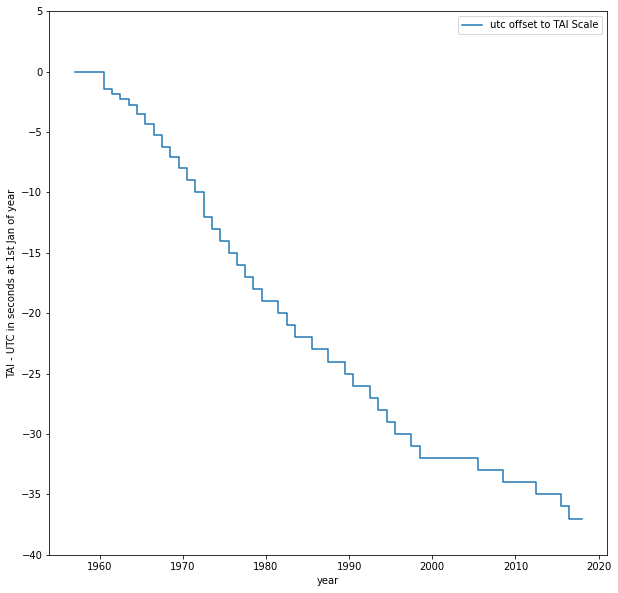

In [18]:
utc = TimeScalesFactory.getUTC()
tai = TimeScalesFactory.getTAI()

timerange = range(1957,2019)

utc_date = [AbsoluteDate(t, 1,  1, 0, 0, 0.0, utc) for t in timerange]
tai_date = [AbsoluteDate(t, 1,  1, 0, 0, 0.0, tai) for t in timerange]

diff_utc = [t1.durationFrom(t2) for t1, t2 in zip(tai_date, utc_date)]
# diff_tt = [t1.durationFrom(t2) for t1, t2 in zip(tai_date, utc_date)]

plot(timerange, diff_utc, label='utc offset to TAI Scale', drawstyle='steps-mid')

legend()
ylabel('TAI - UTC in seconds at 1st Jan of year'); ylim(-40,5)
xlabel('year');